# Climate change through the years
---

Nowadays Climate Change is a hot topic in many discussions and the concern about the long-term alteration of temperature and typical weather patterns in certain places is incresing through the years. We believe the Quotebank datasets will allows us to analyze how the sensitivity about this topic has evolve in society. Note that we will be working with Quotebank data from 2015 to 2020, inclusive.

## Importing data

First, let's mount our Google Drive to use files from it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will now import the necessary libraries to be able to run **pyspark**. Pyspark nicely parallelizes and will let us work with data without importing the whole dataset.

In [ ]:
!pip install tld
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

     |████████████████████████████████| 412 kB 5.1 MB/s 
     |████████████████████████████████| 281.3 MB 24 kB/s 
     |████████████████████████████████| 198 kB 50.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=c7ee2352fb9b8b8ff196cc94a14b5d7e2c7b3db9929e425a4b7019670bdd0992
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config('spark.driver.maxResultSize', '10g').config('spark.executor.memory','8g').config('spark.driver.memory','8g').getOrCreate()

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, FloatType

schema = StructType([
    StructField('date', StringType(), True),
    StructField('numOccurrences', StringType(), True),
    StructField('phase', StringType(), True),
    StructField('probas', ArrayType(ArrayType(StringType()))),
    StructField("qids", ArrayType(StringType()), True),
    StructField('speaker', StringType(), True),
    StructField('quotation', StringType(), True),
    StructField('quoteID', StringType(), True),
    StructField('urls', ArrayType(StringType()), True)
])

## Getting a randomized sample of data

Quotebank dataset is very large. So, for this milestone of the project we will use a randomized sample of data from each year.

In [ ]:
import glob
import pandas as pd

In [ ]:
quote_files = glob.glob("/content/drive/MyDrive/Quotebank/*")
quote_spark = spark.read.schema(schema).option("encoding", "UTF-8").json(quote_files)

# limit the dataset size for preliminary analysis and developing the pipeline
quote_spark.createOrReplaceTempView("data")

quotes = spark.read.schema(schema).option("encoding", "UTF-8").json(quote_files)

quotes = spark.sql("SELECT * FROM data WHERE rand() < 0.015")
quotes.head()

Row(date='2020-02-07 22:11:55', numOccurrences='1', phase='E', probas=[['Seamus Ryan', '0.6351'], ['None', '0.3649']], qids=['Q7440788'], speaker='Seamus Ryan', quotation='All future inquiries should be directed to the principals of the company.', quoteID='2020-02-07-003833', urls=['https://www.koaa.com/news/news5-investigates/homeowners-say-solar-company-left-them-with-a-financial-mess'])

In [ ]:
# we will now save the files
df_pd = quotes.toPandas()
df_pd.to_csv("/content/drive/MyDrive/quote_samples.csv")

In [ ]:
# import the two datasets
quotes = pd.read_csv("/content/drive/MyDrive/quote_samples.csv")
wikidata = spark.read.parquet("/content/drive/MyDrive/Project datasets/speaker_attributes.parquet")

## Exploratory data analysis

As a first step, we will drop all duplicates in the sample as they don't give us any new useful information.

In [ ]:
quotes.drop_duplicates(subset=['quoteID'])

,Unnamed: 0,date,numOccurrences,phase,probas,qids,speaker,quotation,quoteID,urls
0,0,2020-02-18 09:39:38,1,E,"[['Leon Krier', '0.8559'], ['None', '0.1441']]",['Q970000'],Leon Krier,A city is not an accident but the result of co...,2020-02-18-000907,['http://allafrica.com/stories/202002180401.ht...
1,1,2020-02-16 13:00:00,9,E,"[['David Elliott', '0.6047'], ['None', '0.3953']]","['Q2051773', 'Q21280660', 'Q24299940', 'Q37031...",David Elliott,an expectation of the contact Aboriginal and T...,2020-02-16-002091,['http://msn.com/en-au/news/australia/systemic...
2,2,2020-01-10 05:31:29,2,E,"[['Jerry Yates', '0.3703'], ['None', '0.3142']...",['Q23463606'],Jerry Yates,"And because Jerry is under the age of 24, Roth...",2020-01-10-004685,['http://www.gazetteandherald.co.uk/sport/1815...
3,3,2020-03-03 23:38:13,1,E,"[['None', '0.984'], ['President Donald Trump',...",[],None,But you know what? President Donald J. Trump -...,2020-03-03-008475,['https://www.westernjournal.com/black-comedia...
4,4,2020-03-19 12:04:38,4,E,"[['Kareena Kapoor Khan', '0.6061'], ['None', '...",['Q184885'],Kareena Kapoor Khan,Does refusing to run on the treadmill count as...,2020-03-19-013834,['https://www.pinkvilla.com/entertainment/news...
...,...,...,...,...,...,...,...,...,...,...
1735238,1735238,2020-01-12 20:07:07,1,E,"[['John D. Lynch', '0.8007'], ['None', '0.1993']]",['Q1699831'],John D. Lynch,"We can't allow anybody in there, so we're basi...",2020-01-12-046632,['https://www.necn.com/news/national-internati...
1735239,1735239,2020-03-06 05:00:00,1,E,"[['Helen Taylor', '0.8355'], ['None', '0.0945'...","['Q43392993', 'Q43395652', 'Q57420024']",Helen Taylor,What does fiction reading mean to women?,2020-03-06-080274,['https://www.brisbanetimes.com.au/culture/boo...
1735240,1735240,2020-02-04 11:05:00,6,E,"[['None', '0.8854'], ['Elon Musk', '0.1146']]",[],None,"Whether you like Musk or not, he almost always...",2020-02-04-114051,['http://abs-cbnnews.com/business/02/05/20/ico...
1735241,1735241,2020-01-06 08:15:43,1,E,"[['None', '0.8728'], ['Lee Hsien Loong', '0.12...",[],None,While the uncertainties are not completely in ...,2020-01-06-084317,['http://www.businesstimes.com.sg/banking-fina...


We now obtain the number of quotes and features for each quote.

In [ ]:
n_quotes = quotes.shape[0]
n_features = quotes.shape[1]

print('Number of quotes:', n_quotes)
print('Number of features:', n_features)
print('')

quotes.head()

Number of quotes: 1735243
Number of features: 10



,Unnamed: 0,date,numOccurrences,phase,probas,qids,speaker,quotation,quoteID,urls
0,0,2020-02-18 09:39:38,1,E,"[['Leon Krier', '0.8559'], ['None', '0.1441']]",['Q970000'],Leon Krier,A city is not an accident but the result of co...,2020-02-18-000907,['http://allafrica.com/stories/202002180401.ht...
1,1,2020-02-16 13:00:00,9,E,"[['David Elliott', '0.6047'], ['None', '0.3953']]","['Q2051773', 'Q21280660', 'Q24299940', 'Q37031...",David Elliott,an expectation of the contact Aboriginal and T...,2020-02-16-002091,['http://msn.com/en-au/news/australia/systemic...
2,2,2020-01-10 05:31:29,2,E,"[['Jerry Yates', '0.3703'], ['None', '0.3142']...",['Q23463606'],Jerry Yates,"And because Jerry is under the age of 24, Roth...",2020-01-10-004685,['http://www.gazetteandherald.co.uk/sport/1815...
3,3,2020-03-03 23:38:13,1,E,"[['None', '0.984'], ['President Donald Trump',...",[],None,But you know what? President Donald J. Trump -...,2020-03-03-008475,['https://www.westernjournal.com/black-comedia...
4,4,2020-03-19 12:04:38,4,E,"[['Kareena Kapoor Khan', '0.6061'], ['None', '...",['Q184885'],Kareena Kapoor Khan,Does refusing to run on the treadmill count as...,2020-03-19-013834,['https://www.pinkvilla.com/entertainment/news...


We can see that there are some quotes with no speaker assigned. Let's compute the percentage of it and see if we can affort dropping them.

In [ ]:
none_speaker = quotes[quotes['speaker'] == 'None'].shape[0]/n_quotes * 100
print('Percentage of rows with no speaker assigned: {none_speaker} %.'.format(none_speaker=none_speaker))

Percentage of rows with no speaker assigned: 34.56311306255089 %.


As we will work with speakers in future steps, we believe this percentage it is not high enough to support the idea of keeping them. Thus, we will drop them.

In [ ]:
quotes = quotes[quotes['speaker'] != 'None']

n_quotes = quotes.shape[0]
n_features = quotes.shape[1]

print('Number of quotes:', n_quotes)
print('Number of features:', n_features)
print('')

quotes.head()

Number of quotes: 1135489
Number of features: 10



,Unnamed: 0,date,numOccurrences,phase,probas,qids,speaker,quotation,quoteID,urls
0,0,2020-02-18 09:39:38,1,E,"[['Leon Krier', '0.8559'], ['None', '0.1441']]",['Q970000'],Leon Krier,A city is not an accident but the result of co...,2020-02-18-000907,['http://allafrica.com/stories/202002180401.ht...
1,1,2020-02-16 13:00:00,9,E,"[['David Elliott', '0.6047'], ['None', '0.3953']]","['Q2051773', 'Q21280660', 'Q24299940', 'Q37031...",David Elliott,an expectation of the contact Aboriginal and T...,2020-02-16-002091,['http://msn.com/en-au/news/australia/systemic...
2,2,2020-01-10 05:31:29,2,E,"[['Jerry Yates', '0.3703'], ['None', '0.3142']...",['Q23463606'],Jerry Yates,"And because Jerry is under the age of 24, Roth...",2020-01-10-004685,['http://www.gazetteandherald.co.uk/sport/1815...
4,4,2020-03-19 12:04:38,4,E,"[['Kareena Kapoor Khan', '0.6061'], ['None', '...",['Q184885'],Kareena Kapoor Khan,Does refusing to run on the treadmill count as...,2020-03-19-013834,['https://www.pinkvilla.com/entertainment/news...
5,5,2020-03-30 15:35:01,1,E,"[['George Burns', '0.8485'], ['None', '0.1515']]",['Q5537452'],George Burns,"Further, although we have no immediate need fo...",2020-03-30-013219,['http://juniorminingnetwork.com/junior-miner-...


We will now check if there are some missing values in our sample.

In [ ]:
missing_values = quotes.isnull().sum(axis=1)
sum = missing_values[missing_values > 0].count()
print('Percentage of rows with missing values: {sum} %.'.format(sum=sum))

Percentage of rows with missing values: 0 %.


We don't have any missing values so there is no need to take any action.

## Feature processing

For the project we are trying to implement we will need the following features:

1.   date
2.   numOccurrences
3.   qids
4.   speaker
5.   quotation
6.   quoteID
7.   urls

We will not use the following features:

1.   phase
2.   probas

Thus, we will drop the these features.

In [ ]:
quotes = quotes[['date', 'numOccurrences', 'qids', 'speaker', 'quotation', 'quoteID', 'urls']]
quotes.head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls
0,2020-02-18 09:39:38,1,['Q970000'],Leon Krier,A city is not an accident but the result of co...,2020-02-18-000907,['http://allafrica.com/stories/202002180401.ht...
1,2020-02-16 13:00:00,9,"['Q2051773', 'Q21280660', 'Q24299940', 'Q37031...",David Elliott,an expectation of the contact Aboriginal and T...,2020-02-16-002091,['http://msn.com/en-au/news/australia/systemic...
2,2020-01-10 05:31:29,2,['Q23463606'],Jerry Yates,"And because Jerry is under the age of 24, Roth...",2020-01-10-004685,['http://www.gazetteandherald.co.uk/sport/1815...
4,2020-03-19 12:04:38,4,['Q184885'],Kareena Kapoor Khan,Does refusing to run on the treadmill count as...,2020-03-19-013834,['https://www.pinkvilla.com/entertainment/news...
5,2020-03-30 15:35:01,1,['Q5537452'],George Burns,"Further, although we have no immediate need fo...",2020-03-30-013219,['http://juniorminingnetwork.com/junior-miner-...


In [ ]:
quotes.dtypes

date              object
numOccurrences     int64
qids              object
speaker           object
quotation         object
quoteID           object
urls              object
dtype: object

We observe that the 'date' column is dtype Object, we transform it to datetime dtype.

In [ ]:
quotes['date_format'] = pd.to_datetime(quotes['date'])

## Cleaning texts

Text is a form of unstructured data. Unfortunately, machines cannot read raw text like that so we will first clean the quotation column.
* **Case normalization**: When we write, we capitalize various words in our sentence/paragraph for different reasons. It’s important to normalize the case of our words so that every word is in the same case and the computer doesn’t process the same word as 2 different tokens.
* **Removing stopwords**: In English there are words that are used more frequently than others. However, they do not necessarily add more value to a sentence, hence it is safe to say that we can ignore them and remove them from our text.

In [ ]:
# Importing the libraries
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'our', 'as', 'of', "aren't", "weren't", 'didn', 'is', 'during', 'than', 'll', 'myself', 'which', 'him', "mustn't", 'each', 'below', 'then', 'ain', 'when', 'further', 'any', "didn't", 'it', 'if', 'or', 'yourself', "mightn't", 're', 'your', 'again', 'up', 'with', 'me', 's', 'by', 'such', 'mightn', 'she', 'wasn', 'aren', 'most', 've', 'all', 'ma', 'we', 'has', 'yourselves', 'only', 't', 'do', 'herself', 'its', 'his', 'under', 'after', 'more', "you're", "wasn't", 'whom', 'this', 'needn', 'now', 'very', 'y', "hasn't", 'while', 'isn', 'out', 'the', 'where', "should've", "shouldn't", 'down', 'are', 'above', "isn't", 'won', 'doesn', 'few', "won't", 'have', "it's", 'he', 'what', 'these', 'a', "wouldn't", 'in', 'itself', 'been', 'was', "needn't", 'having', 'until', 'but', 'were', 'hasn', 'that', 'some', 'hadn', "haven't", 'himself', 'into', "don't", 'hers', 'between', 'how', 'through',

* **Removing unicode**: ASCII formats emojis and other non-ASCII characters as Unicode. Essentially, Unicode is a universal character encoding standard in which each character and symbol in all languages have an assigned code. Unicode is required because it is the only encoding standard that allows us to retrieve or join data using a variety of different languages but the issue is that it’s unreadable in ASCII format.
* **Removing punctuation**: Punctuation is not valuable for the problem that we are attempting to solve, it just adds noise, so, we are better off removing them from our data.

In [ ]:
import string

punctuation = set(string.punctuation) 
print(punctuation)

{'+', '~', '}', '$', "'", '?', '(', '/', ')', '\\', ',', '[', '|', '.', '&', '_', ']', '>', '!', '*', '@', '{', ':', '-', '=', '#', ';', '`', '<', '^', '%', '"'}


* **Stemming**: We want the computer to be able to understand that “walked”, “walk” and “walking” are all merely different tenses of the same word, otherwise, they’d be treated differently. In linguistic morphology and information retrieval, stemming is the process of reducing inflected words to their word stem, base, or root form — generally a written word form.

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

In [ ]:
""" Implement function that cleans the string text given in the parameters.""" 
def clean_text(text):
  # 1. Case normalization: Lowercasing the text
  text = text.lower()
  
  # 2. Removing Stopwords
  text = " ".join([word for word in text.split() if word not in stop_words])

  # 3. Removing unicode: encoding text to ASCII format and decoding it after
  text = text.encode(encoding="ascii", errors="ignore")
  text = text.decode()

  # 4. Removing punctuation
  text = "".join([ch for ch in text if ch not in punctuation])

  # 5. Stemming and removing extra whitespace
  text = " ".join([stemmer.stem(word) for word in text.split()])

  return text

In [ ]:
# Example to see if function clean_text() works
text = "Python is easy \u200c to learn. Let's do it!     I am starting to believe it" 
text = clean_text(text)
text

'python easi learn let it start believ'

In [ ]:
# Cleaning quotation column
quotes['clean_quotation'] = quotes['quotation'].apply(lambda x: clean_text(x))

## Selecting quotations that talk about climate change

After cleaning the text of the quotations, we can check which of them talk about climate change. In order to do that, we will check if these quotations contain words from a list of climate related words that we got from [wikipedia](https://en.wikipedia.org/wiki/Glossary_of_climate_change).

In [ ]:
!pip install requests

import requests

response = requests.get(
	url="https://en.wikipedia.org/wiki/Glossary_of_climate_change",
)

print(response.status_code)

200


We are also cleaning this data so it will match the quotations.

In [ ]:
!pip install beautifulsoup4

from bs4 import BeautifulSoup

soup = BeautifulSoup(response.content, 'html.parser')

climate_set = set()
for s in soup.find_all('dt', attrs={'glossary'}):
  climate_set.add(str(s.text))

# Clean climate set
climate_set = [clean_text(word) for word in climate_set]

climate_related_words = '|'.join([word for word in climate_set])
climate_related_words

'solar wind|carbon tax|tip point climat system|climat system|arctic amplif|interdecad pacif oscil ipo|kyoto protocol|cosmic ray|climat chang|strand asset|albedo|enter ferment|global warm denial|clathrat gun hypothesi|without measur wom|world climat report|cool tropic paradox|glacial earthquak|nitrou oxid|ice core|climat forc|invas speci|polici measur pam|forest dieback|climat chang feedback|phenolog|climat sensit|emiss trade|homogen|season creep|global warm gw|climat crisi|arctic oscil ao|polar citi|holocen|carbon dioxid|freon|mediev warm period|cap trade|addit measur wam|el niosouthern oscil enso|antigreenhous effect|instrument temperatur record|argo|glacial motion|ozon layer|sea level rise|regim shift|proxi|pacif decad oscil pdo|atmospher window|irradi|paleoclimatolog|holocen climat optimum|volcan|global cool|climatolog|ozon deplet|mitig global warm|atmospher scienc|urban heat island|global climat regim|ocean planet|ecoeffici|paleoceneeocen thermal maximum petm|greenhous ga inventori

Let's now filter the data and select only those rows related to climate change. For this purpose we will only take quotes that contain climate related words.

In [ ]:
climate_quotations = quotes[quotes['clean_quotation'].str.contains(climate_related_words)].copy()
climate_quotations.head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls,date_format,clean_quotation
31,2020-02-13 20:48:02,1,['Q5387591'],Eric Swanson,Weather is a serious issue!,2020-02-13-117618,['https://www.dvidshub.net/news/363017/third-m...,2020-02-13 20:48:02,weather seriou issu
179,2020-01-19 05:02:00,1,"['Q62870', 'Q7608940']",Stephen Cook,Some of these ideas will play in to our existi...,2020-01-19-035805,['http://www.telegraph.co.uk/business/2020/01/...,2020-01-19 05:02:00,idea play exist oil ga busi make effici lower ...
445,2020-01-15 10:03:36,1,"['Q471851', 'Q56597630', 'Q56725722', 'Q6140167']",James Murdoch,promoting false scepticism about climate chang...,2020-01-15-066837,['https://www.carbonbrief.org/daily-brief/blac...,2020-01-15 10:03:36,promot fals sceptic climat chang deadli bushfi...
452,2020-01-29 18:39:34,3,"['Q15995308', 'Q16185474', 'Q24734892', 'Q2519...",Greg Miller,The tunnel work will have a huge impact on how...,2020-01-29-093546,"['http://home.nzcity.co.nz/nl.aspx?4432710', '...",2020-01-29 18:39:34,tunnel work huge impact freight move northland...
528,2020-01-03 22:30:03,1,['Q7611923'],Steve Benen,"The United States is sending approximately 3,0...",2020-01-03-061651,['http://www.msnbc.com/rachel-maddow-show/frid...,2020-01-03 22:30:03,unit state send approxim 3000 soldier middl ea...


From now on, we will work with cleaned quotations.

## Frequency of climate related words per quotation

The first step will be to measure amount of climate related words we find in each quotation.

In [ ]:
climate_quotations['n_climate_words'] = climate_quotations['clean_quotation'].str.count(climate_related_words)
climate_quotations.head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls,date_format,clean_quotation,n_climate_words
31,2020-02-13 20:48:02,1,['Q5387591'],Eric Swanson,Weather is a serious issue!,2020-02-13-117618,['https://www.dvidshub.net/news/363017/third-m...,2020-02-13 20:48:02,weather seriou issu,1
179,2020-01-19 05:02:00,1,"['Q62870', 'Q7608940']",Stephen Cook,Some of these ideas will play in to our existi...,2020-01-19-035805,['http://www.telegraph.co.uk/business/2020/01/...,2020-01-19 05:02:00,idea play exist oil ga busi make effici lower ...,1
445,2020-01-15 10:03:36,1,"['Q471851', 'Q56597630', 'Q56725722', 'Q6140167']",James Murdoch,promoting false scepticism about climate chang...,2020-01-15-066837,['https://www.carbonbrief.org/daily-brief/blac...,2020-01-15 10:03:36,promot fals sceptic climat chang deadli bushfi...,1
452,2020-01-29 18:39:34,3,"['Q15995308', 'Q16185474', 'Q24734892', 'Q2519...",Greg Miller,The tunnel work will have a huge impact on how...,2020-01-29-093546,"['http://home.nzcity.co.nz/nl.aspx?4432710', '...",2020-01-29 18:39:34,tunnel work huge impact freight move northland...,1
528,2020-01-03 22:30:03,1,['Q7611923'],Steve Benen,"The United States is sending approximately 3,0...",2020-01-03-061651,['http://www.msnbc.com/rachel-maddow-show/frid...,2020-01-03 22:30:03,unit state send approxim 3000 soldier middl ea...,1


We are also computing the term frequency. 

In [ ]:
climate_quotations['term_frequency'] = climate_quotations['n_climate_words']/climate_quotations['clean_quotation'].str.count(' ').add(1)
climate_quotations.head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls,date_format,clean_quotation,n_climate_words,term_frequency
31,2020-02-13 20:48:02,1,['Q5387591'],Eric Swanson,Weather is a serious issue!,2020-02-13-117618,['https://www.dvidshub.net/news/363017/third-m...,2020-02-13 20:48:02,weather seriou issu,1,0.333333
179,2020-01-19 05:02:00,1,"['Q62870', 'Q7608940']",Stephen Cook,Some of these ideas will play in to our existi...,2020-01-19-035805,['http://www.telegraph.co.uk/business/2020/01/...,2020-01-19 05:02:00,idea play exist oil ga busi make effici lower ...,1,0.090909
445,2020-01-15 10:03:36,1,"['Q471851', 'Q56597630', 'Q56725722', 'Q6140167']",James Murdoch,promoting false scepticism about climate chang...,2020-01-15-066837,['https://www.carbonbrief.org/daily-brief/blac...,2020-01-15 10:03:36,promot fals sceptic climat chang deadli bushfi...,1,0.100000
452,2020-01-29 18:39:34,3,"['Q15995308', 'Q16185474', 'Q24734892', 'Q2519...",Greg Miller,The tunnel work will have a huge impact on how...,2020-01-29-093546,"['http://home.nzcity.co.nz/nl.aspx?4432710', '...",2020-01-29 18:39:34,tunnel work huge impact freight move northland...,1,0.030303
528,2020-01-03 22:30:03,1,['Q7611923'],Steve Benen,"The United States is sending approximately 3,0...",2020-01-03-061651,['http://www.msnbc.com/rachel-maddow-show/frid...,2020-01-03 22:30:03,unit state send approxim 3000 soldier middl ea...,1,0.037037


We display the quotes with the highest amount of climate related word and the highest frequency.

In [ ]:
climate_quotations.sort_values(by=['term_frequency'], ascending=False).head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls,date_format,clean_quotation,n_climate_words,term_frequency
159623,2019-12-18 18:00:02,4,['Q7381416'],Russell Ciochon,"There was a change in climate,",2019-12-18-079265,['https://phys.org/news/2019-12-age-settlement...,2019-12-18 18:00:02,chang climat,1,0.5
301916,2019-07-21 11:31:47,3,['Q349125'],Dejan Lovren,"We adapt to everything,",2019-07-21-034743,['https://www.goal.com/en/news/pressure-wont-a...,2019-07-21 11:31:47,adapt everyth,1,0.5
1681685,2015-03-23 09:05:39,4,['Q18166062'],Mereseini Vuniwaqa,Climate: Knowledge for Climate Action,2015-03-23-010797,['http://reliefweb.int/report/world/wmo-statem...,2015-03-23 09:05:39,climat knowledg climat action,2,0.5
1358470,2016-04-20 04:19:38,5,['Q7518520'],Simon Corbell,adapt to the effects climate change,2016-04-20-003986,['http://watoday.com.au/act-news/professor-kat...,2016-04-20 04:19:38,adapt effect climat chang,2,0.5
3768,2020-02-11 03:26:26,10,['Q18097239'],Akinwumi Adesina,"There has to be climate justice,",2020-02-11-088806,['https://www.seattletimes.com/nation-world/na...,2020-02-11 03:26:26,climat justic,1,0.5


We believe that there are quotations that, even if they contain climate related word, they are not related to climate change as the term frequency is not high enough. We will then discard all the quotes where the frequency is lower than the median.

In [ ]:
median = climate_quotations['term_frequency'].median()
climate_quotations = climate_quotations[climate_quotations['term_frequency'] > median]

print('Number of quotes:', climate_quotations.shape[0])
print('')

climate_quotations.head()

Number of quotes: 4601



,date,numOccurrences,qids,speaker,quotation,quoteID,urls,date_format,clean_quotation,n_climate_words,term_frequency
31,2020-02-13 20:48:02,1,['Q5387591'],Eric Swanson,Weather is a serious issue!,2020-02-13-117618,['https://www.dvidshub.net/news/363017/third-m...,2020-02-13 20:48:02,weather seriou issu,1,0.333333
179,2020-01-19 05:02:00,1,"['Q62870', 'Q7608940']",Stephen Cook,Some of these ideas will play in to our existi...,2020-01-19-035805,['http://www.telegraph.co.uk/business/2020/01/...,2020-01-19 05:02:00,idea play exist oil ga busi make effici lower ...,1,0.090909
445,2020-01-15 10:03:36,1,"['Q471851', 'Q56597630', 'Q56725722', 'Q6140167']",James Murdoch,promoting false scepticism about climate chang...,2020-01-15-066837,['https://www.carbonbrief.org/daily-brief/blac...,2020-01-15 10:03:36,promot fals sceptic climat chang deadli bushfi...,1,0.100000
1398,2020-01-22 20:13:58,2,['Q6767411'],Mark Dreyfus,We are going to be demanding from now until th...,2020-01-22-103088,['http://www.hawkesburygazette.com.au/story/65...,2020-01-22 20:13:58,go demand next elect govern take real action c...,1,0.111111
1739,2020-04-13 11:35:20,1,"['Q3641334', 'Q4933705']",Bob Quick,"The world changed, and our team had to figure ...",2020-04-13-048415,['https://www.lanereport.com/124254/2020/04/ma...,2020-04-13 11:35:20,world chang team figur effect way adapt,1,0.142857


\For the moment we will be using the median as threshold but as we know that this is not the optimal way to go, we will improve it for next milestone. For the M3 we will rely on ClimateBERT, a transformer model that is able to extract climate change related text.

## Time series analysis

Let's analyze now the frequency of climate change related quotes through the years and months in order to find the time lapses where climate change was a hot topic.

First, we will group the quotes by year.

In [ ]:
climate_quotations['year'] = climate_quotations['date_format'].dt.year

In [ ]:
yearly_quotes = climate_quotations.groupby( ['year'] ).size().to_frame(name = 'count')
yearly_quotes

,count
year,
2015,364
2016,209
2017,397
2018,380
2019,438
2020,95


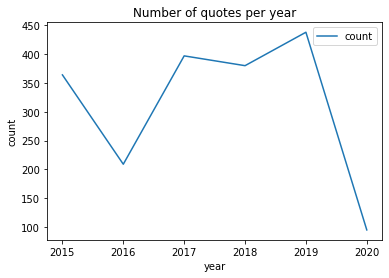

In [ ]:
plot = yearly_quotes.plot(xlabel='year', ylabel='count', title='Number of quotes per year')

We observe that the number of climate quotations increases through the years so it seems that the population is getting more concern about climate change. However, to fully capture this we should look at the proportion of quotes that are climate related. To do this we will look at the proportion of quotes in a specific year that are climate related. 

We also observe that the number of quotes in 2020 is significantly lower, this can be attribute to the fact that the quotes stop on March 2020.

Now let's zoom in, grouping by month.

In [ ]:
climate_quotations['month'] = climate_quotations['date_format'].dt.month

In [ ]:
monthly_quotes = climate_quotations.groupby( ['year', 'month'] ).size().to_frame(name = 'count')
monthly_quotes

count
year month       
2015 1         75
     2         57
     3         72
     4         64
     5         33
...           ...
2019 12        93
2020 1        100
     2         84
     3         54
     4         21

[63 rows x 1 columns]

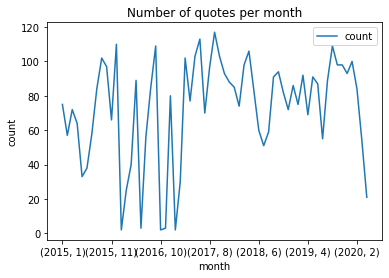

In [ ]:
plot = monthly_quotes.plot(xlabel='month', ylabel='count', title='Number of quotes per month')

This plot reveals a high-degree of variance across months. In particular, in 2016 there the conversation surrounding climate change was far less uniform and experienced spikes likely related with external events. After 2016 the conversation seems to become more uniform. 

## Quote occurrences distribution

Let's see which are the most mentioned quotes in journals. This quotes will have a more important value.

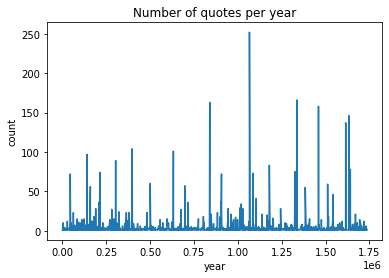

In [ ]:
plot = climate_quotations['numOccurrences'].plot(xlabel='quoteID', ylabel='occurrences', title='Number of occurrences per quote')

We observe that the data look heterogeneous. Quotes can be either frequently or barely mentioned.

In [ ]:
occurrences = climate_quotations.groupby(['numOccurrences']).size().to_frame(name = 'count')
plot = occurrences.plot(xlabel='numOccurrences', ylabel='count', title='Quote distribution')

In [ ]:
climate_quotations.sort_values(by=['numOccurrences'], ascending=False).head()

,date,numOccurrences,qids,speaker,quotation,quoteID,urls,clean_quotation,n_climate_words,tf,term_frequency,date_format,month,year
1066279,2017-06-01 02:05:00,252,['Q57661'],Jean-Claude Juncker,"the full implementation, without nuances, of t...",2017-06-01-116013,['http://www.timescolonist.com/protests-new-cl...,full implement without nuanc pari climat agree...,1,0.142857,0.142857,2017-06-01 02:05:00,6,2017
1337639,2016-08-30 01:36:12,166,['Q4756372'],Andrew Blakers,After the fiasco involving CSIRO climate scien...,2016-08-30-004143,['http://armidaleexpress.com.au/story/4130508/...,fiasco involv csiro climat scientist potenti f...,2,0.200000,0.200000,2016-08-30 01:36:12,8,2016
839935,2017-10-18 00:00:00,163,"['Q14948632', 'Q22095942', 'Q6307307']",Julian King,terrorists don't stand still. They change and ...,2017-10-18-121498,['http://montrealgazette.com/pmn/news-pmn/eu-u...,terrorist stand still chang adapt method need ...,2,0.200000,0.200000,2017-10-18 00:00:00,10,2017
1459791,2015-08-28 02:25:30,158,['Q15525008'],Jackie Kelly,"There's just no feedback there, so you rely co...",2015-08-28-097084,['http://www.brisbanetimes.com.au/act-news/can...,there feedback there reli complet school repor...,1,0.125000,0.125000,2015-08-28 02:25:30,8,2015
1632886,2015-12-12 17:37:57,146,"['Q3675860', 'Q5112653']",Christopher Joyce,Any greenhouse gases emitted would be balanced...,2015-12-12-004436,['http://www.ktoo.org/2015/12/12/2-degrees-100...,greenhous gase emit would balanc zero remov eq...,3,0.142857,0.142857,2015-12-12 17:37:57,12,2015


## Building the embedding

- We first define a function to get the top level domains of the urls in order to get the journal name.
- Next we calculate the tf-idf for speaker-domain pairs.
- after we calculate the cosine similarity between sites

In [ ]:
from tld import get_tld

def get_domain(urls):
    tlds = [get_tld(k, as_object=True).fld for k in urls]
    return tlds

get_domain_udf = udf(get_domain, ArrayType(StringType()))

In [ ]:
climate_quotations['clean_quotation'] = climate_quotations['quotation'].apply(lambda x: clean_text(x))



In [ ]:
import glob
quote_files = glob.glob("/content/drive/MyDrive/Quotebank/*")

# define a function to get the top level domains 
from tld import get_tld

def get_domain(urls):
    tlds = [get_tld(k, as_object=True).fld for k in urls]
    return tlds

get_domain_udf = udf(get_domain, ArrayType(StringType()))

limited = quotes.limit(3000000)

quotes_2019 = limited.withColumn("flds", get_domain_udf("urls"))

# drop speakers with None
quotes_2019 = quotes_2019.filter(quotes_2019.speaker != "None")

speakers = quotes_2019.groupBy('speaker').count()
speakers = speakers.filter(col("count")>9)
# join onto the speakers
quotes_2019 = quotes_2019.join(speakers, on = 'speaker', how = 'inner')
quotes_2019_exploded = quotes_2019.select(*['speaker','flds'])

# here we explode on the flds list
# this will provide us with a row for every fld
quotes_2019_exploded = quotes_2019_exploded.select(quotes_2019_exploded.speaker, explode(quotes_2019_exploded.flds).alias('fld'))
count_fld = quotes_2019_exploded.groupBy('fld').agg({'fld':'count'})

count_fld = count_fld.filter(count_fld['count(fld)'] > 99)

# analysis to get the term-frequencies and idf
quotes_2019_exploded = quotes_2019_exploded.join(count_fld, on ='fld')
quotes_2019_exploded = quotes_2019_exploded.cache()
quotes_2019_exploded= quotes_2019_exploded.select('fld','speaker')
quotes_2019_grouped = quotes_2019_exploded.groupBy(*['speaker','fld']).count()
quotes_2019_idf = quotes_2019_grouped.groupBy("speaker").count()
quotes_2019_idf = quotes_2019_idf.select(col('speaker').alias('speaker'), col('count').alias('unique_speakers'))
quotes_2019_grouped = quotes_2019_grouped.join(quotes_2019_idf, on = 'speaker')
quotes_2019_grouped.write.parquet("frequency_table2.parquet")
frequencies = spark.read.load('frequency_table2.parquet').toPandas()

frequencies.to_csv('/content/drive/MyDrive/frequency_table.csv')

In [ ]:
frequencies = pd.read_csv('/content/drive/MyDrive/frequency_table.csv')

In [ ]:
frequencies['fld_count'] = frequencies.groupby('fld')['count'].transform('sum')

frequencies = frequencies[frequencies['fld_count'] > 60]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
import numpy as np
N = frequencies['fld'].nunique()
frequencies['idf'] = frequencies['unique_speakers'].apply(lambda x: np.log(N/x))
frequencies['tfidf'] = frequencies['idf'] * frequencies['count']

# we will pivot 
pivoted = frequencies.pivot(index='fld',columns ='speaker', values='tfidf')

pivoted = pivoted.fillna(0)


# to do the LSA we need to run PCA
from sklearn.decomposition import PCA 
pca = PCA(150)
vecs = pca.fit_transform(pivoted)

vecs_df = pd.DataFrame(vecs, index=pivoted.index)


# we will use cosine similarity to find similarity
from sklearn.metrics import pairwise
cosine_similarity = pairwise.cosine_similarity(vecs_df.values)

cosine_similarity_df = pd.DataFrame(cosine_similarity, index=vecs_df.index,columns = vecs_df.index)

breitbart_sim = cosine_similarity_df['breitbart.com'].sort_values(ascending=False).reset_index()

In [ ]:
breitbart_sim.head(10)

,fld,breitbart.com
0,breitbart.com,1.000000
1,upi.com,0.807099
2,voanews.com,0.721127
3,metro.us,0.713068
4,westernjournal.com,0.709644
5,newdelhitimes.com,0.702803
6,news12.com,0.697857
7,kdhnews.com,0.692948
8,newsmax.com,0.687800
9,ibtimes.com,0.685697


In [ ]:
# save for tensorflow embedding
vecs_df.to_csv("/content/drive/MyDrive/vecs.tsv", sep='\t',header=False)
metadata = vecs_df.reset_index('fld')['fld'].to_csv("/content/drive/MyDrive/metadata.tsv", header=False, sep='\t',index=False)


In [ ]:
# we will import the bias scores from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QAN5VX
bias_scores = pd.read_csv('/content/drive/MyDrive/bias_scores.csv')

In [ ]:
# we want to find which news site is farthest left and right
# next step will be define a partisan_dimension using these values
bias_scores.sort_values(by='fb_score').dropna(subset=['fb_score'])

,domain,score,fb_score,mturk_score,budak_score,allsides_score,allsides_score_community,pew_score
2367,readersupportednews.org,-0.7836,-0.9984,NaN,NaN,NaN,NaN,NaN
1001,act.weareultraviolet.org,-0.8069,-0.9710,NaN,NaN,NaN,NaN,NaN
1070,commondreams.org,-0.6526,-0.9673,-0.166667,NaN,NaN,NaN,NaN
943,thenewcivilrightsmovement.com,-0.7471,-0.9643,-0.500000,NaN,NaN,NaN,NaN
241,jezebel.com,-0.6633,-0.9487,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1090,lifenews.com,0.8814,0.9664,NaN,NaN,NaN,NaN,NaN
854,youngcons.com,0.9023,0.9685,NaN,NaN,NaN,NaN,NaN
1617,glennbeck.com,0.9013,0.9690,NaN,NaN,NaN,NaN,0.250
2198,rushlimbaugh.com,0.8715,1.0077,NaN,NaN,NaN,NaN,0.282
